In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Multiply, Conv2D, Add
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input, Dropout, BatchNormalization, MaxPooling2D, DepthwiseConv2D
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CosineDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import os
from PIL import Image
from tensorflow.keras.models import Model

# After downloading Air-Pollution-Image-Dataset-From-India-and-Nepal dataset from kaggle, extract it and pass the path for all the respective csv file for training, validation and test.

In [100]:
# Specify the file paths for the training, validation, and testing CSV files
train_csv_file = 'Datasets/train_data.csv'
val_csv_file = 'Datasets/val_data.csv'
test_csv_file = 'Datasets/testing_data.csv'

In [101]:
from sklearn.utils.class_weight import compute_class_weight
import cv2
# Read the training CSV file into a DataFrame
train_df = pd.read_csv(train_csv_file)

# Balance the dataset by computing class weights
print(train_df['AQI_Class'].value_counts(normalize=True))
classes = np.unique(train_df['AQI_Class'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['AQI_Class'])
class_weight_dict = dict(zip(classes, class_weights))


# Read the validation CSV file into a DataFrame
val_df = pd.read_csv(val_csv_file)

# Read the testing CSV file into a DataFrame
test_df = pd.read_csv(test_csv_file)

def full_preprocess(image):
    image = np.array(image, dtype=np.uint8)

    ### 1. HSV 色彩增強
    if np.random.rand() < 0.5:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        sat_scale = np.random.uniform(1.0, 1.3)  # 避免太誇張
        hsv[..., 1] = np.clip(hsv[..., 1] * sat_scale, 0, 255)
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    ### 2. 模擬霧氣（亮度與對比）：適當調整 alpha/beta 範圍
    if np.random.rand() < 0.5:
        alpha = np.random.uniform(0.7, 0.95)  # 對比度減少
        beta = np.random.uniform(5, 20)       # 亮度增加
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    ### 3. CLAHE（局部亮度增強）
    if np.random.rand() < 0.7:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        image = cv2.merge((l, a, b))
        image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)

    ### 4. 模糊（模擬霧濛感）
    if np.random.rand() < 0.3:
        k = np.random.choice([3, 5])
        image = cv2.GaussianBlur(image, (k, k), 0)

    ### 5. Resize & Normalize
    image = image.astype('float32') / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    return image

def only_normalize(image):
    image = image.astype('float32') / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std
    return image


path = 'Datasets/Images'

# Create ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=full_preprocess,
    # augmentation parameters
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=only_normalize
)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

AQI_Class
c_Unhealthy_for_Sensitive_Groups    0.233882
d_Unhealthy                         0.214222
e_Very_Unhealthy                    0.179242
b_Moderate                          0.128431
a_Good                              0.125878
f_Severe                            0.118345
Name: proportion, dtype: float64
Found 7833 validated image filenames belonging to 6 classes.
Found 1959 validated image filenames belonging to 6 classes.
Found 2448 validated image filenames belonging to 6 classes.


# write your code here to create and train your model for image classificatoin for AQI class

In [ ]:
def cbam_block(feature_map, reduction=16):
    # CBAM (Convolutional Block Attention Module) implementation
    # used to enhance feature maps by applying channel and spatial attention
    channel = feature_map.shape[-1]

    # ----- Channel Attention -----
    avg_pool = GlobalAveragePooling2D()(feature_map)
    max_pool = GlobalMaxPooling2D()(feature_map)
    shared_dense = Dense(channel // reduction, activation='relu')
    shared_out = Dense(channel)

    avg_out = shared_out(shared_dense(avg_pool))
    max_out = shared_out(shared_dense(max_pool))
    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_attention = Reshape((1,1,channel))(channel_attention)
    feature_map = Multiply()([feature_map, channel_attention])

    # ----- Spatial Attention -----
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(feature_map)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(feature_map)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    feature_map = Multiply()([feature_map, spatial_attention])

    return feature_map

def ghost_module(x, filters, kernel_size=3, stride=1, weight_decay=1e-3):
    # Ghost module implementation
    init_channels = filters * 3 // 4

    # Primary convolution
    primary = Conv2D(init_channels, kernel_size, strides=stride, padding='same',
                     kernel_regularizer=l2(weight_decay))(x)
    primary = BatchNormalization()(primary)
    primary = Activation('relu')(primary)

    # Ghost feature maps
    ghost = DepthwiseConv2D(kernel_size, padding='same')(primary)
    ghost = Conv2D(filters - init_channels, 1, strides=1, padding='same', kernel_regularizer=l2(weight_decay))(ghost)
    ghost = BatchNormalization()(ghost)
    ghost = Activation('relu')(ghost)
    
    x = Concatenate()([primary, ghost])
    return x

def ghost_residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, weight_decay=1e-3):
    shortcut = x

    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='valid', kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = ghost_module(x, filters, kernel_size, stride=stride, weight_decay=weight_decay)
    x = ghost_module(x, filters, kernel_size, stride=1, weight_decay=weight_decay)

    # insert CBAM block
    x = cbam_block(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x


def make_conv_stage(x, filters, num_blocks, stride=2, weight_decay=1e-3):
    # First block of the stage with stride (downsampling if stride=2)
    x = ghost_residual_block(x, filters, stride=stride, conv_shortcut=True, weight_decay=weight_decay)
    # Remaining blocks with stride=1
    for _ in range(num_blocks - 1):
        x = ghost_residual_block(x, filters, stride=1, conv_shortcut=False, weight_decay=weight_decay)
    return x

def build_ghost_resnet101(input_shape=(224, 224, 3), num_classes=6, weight_decay=1e-3, initializer=HeNormal(seed=42)):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # ResNet-101 Stages: Conv2_x (3 blocks), Conv3_x (4 blocks), Conv4_x (23 blocks), Conv5_x (3 blocks)
    x = make_conv_stage(x, 64, num_blocks=3, stride=1, weight_decay=weight_decay)   # Conv2_x
    x = make_conv_stage(x, 128, num_blocks=4, stride=2, weight_decay=weight_decay)  # Conv3_x
    x = make_conv_stage(x, 256, num_blocks=23, stride=2, weight_decay=weight_decay) # Conv4_x
    x = make_conv_stage(x, 512, num_blocks=3, stride=2, weight_decay=weight_decay)  # Conv5_x
    
    # Final Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay), kernel_initializer=initializer)(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay), kernel_initializer=initializer)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay), kernel_initializer=initializer)(x)
    
    model = Model(inputs, outputs)
    return model

# Create the model
model = build_ghost_resnet101(input_shape=(224, 224, 3), num_classes=6, weight_decay=1e-4)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
import tensorflow_addons as tfa

lr_schedule = CosineDecay(initial_learning_rate=0.0001, decay_steps=1000)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
    metrics=['accuracy', Precision(), Recall()]
)

In [ ]:
#train you model here

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=300,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

model.save('resnet101.h5')

/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 104s 269ms/step - AUC: 0.6278 - accuracy: 0.2804 - loss: 54.2096 - val_AUC: 0.6600 - val_accuracy: 0.2670 - val_loss: 41.3197 - learning_rate: 1.0000e-04
Epoch 2/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - AUC: 0.8035 - accuracy: 0.4532 - loss: 37.6770 - val_AUC: 0.8116 - val_accuracy: 0.4507 - val_loss: 29.2431 - learning_rate: 1.0000e-04
Epoch 3/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - AUC: 0.8555 - accuracy: 0.5228 - loss: 27.0276 - val_AUC: 0.9142 - val_accuracy: 0.6172 - val_loss: 21.5117 - learning_rate: 1.0000e-04
Epoch 4/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - AUC: 0.8832 - accuracy: 0.5669 - loss: 20.3165 - val_AUC: 0.8886 - val_accuracy: 0.5564 - val_loss: 16.8882 - learning_rate: 1.0000e-04
Epoch 5/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - AUC: 0.9017 - accuracy: 0.5989 - loss: 15.9339 - val_AUC: 0.9345 - val_accuracy: 0.6784 - val_loss: 13.4629 - learning_rate: 1.0000e-04
Epoch 6/200
245/245 ━━━━━━━━━

# plot your Training Accuracy and validation accuracy here

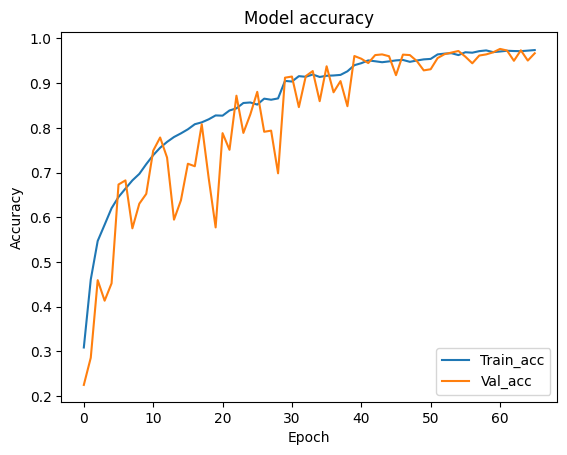

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend(['Train_acc', 'Val_acc'], loc='lower right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Val_loss'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
val_preds = model.predict(val_generator)
val_labels = val_generator.classes
val_auc = roc_auc_score(
    pd.get_dummies(val_labels),
    val_preds,
    multi_class='ovr',
    average='macro'
)
print(f"Validation ROC AUC: {val_auc:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Validation ROC AUC: 0.4999


# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [ ]:
test_probabilities = model.predict(test_generator)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
test_probabilities_df.to_csv('Outputs/test_results.csv', index=False)


/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

2025-06-17 19:37:53.994335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3937', 104 bytes spill stores, 104 bytes spill loads

2025-06-17 19:37:54.008312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3944', 52 bytes spill stores, 52 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step


In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - AUC: 0.9996 - accuracy: 0.9839 - loss: 0.1782
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


In [ ]:
# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = f1_score(y_true, y_pred, average='macro')

# Print the F1 scores for each class
for i, f1 in enumerate(f1_scores):
    print("Class {}: F1 Score = {:.4f}".format(i, f1))

# Print the average F1 score
print("Average F1 Score: {:.4f}".format(average_f1_score))
print()
print("Test Accuracy: {:.4f}".format(test_accuracy))

Class 0: F1 Score = 0.1270
Class 1: F1 Score = 0.1348
Class 2: F1 Score = 0.2340
Class 3: F1 Score = 0.2412
Class 4: F1 Score = 0.1333
Class 5: F1 Score = 0.1075
Average F1 Score: 0.1630

Test Accuracy: 0.9820


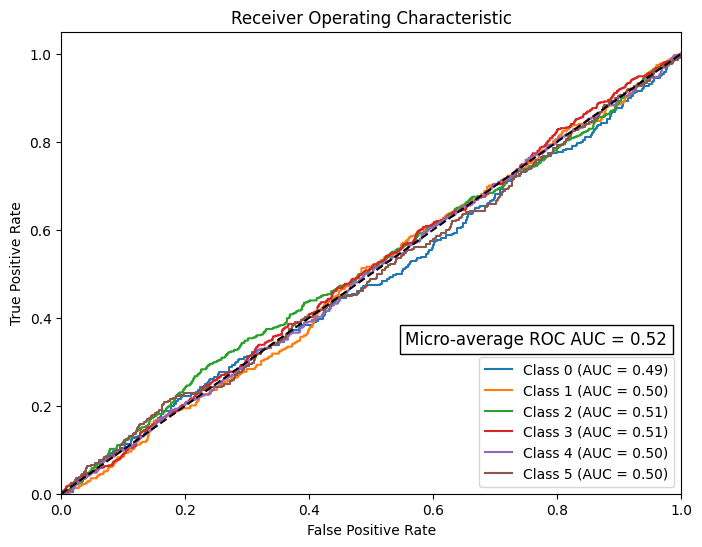

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))

# Calculate the ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_pred_prob, average='micro')

# Plot the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random chance curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Add micro-average ROC AUC score to the plot
plt.text(0.555, 0.34, 'Micro-average ROC AUC = %0.2f' % roc_auc_scores, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Generate predictions for the training data
train_pred = model.predict(train_generator)
train_pred = np.argmax(train_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the validation data
val_pred = model.predict(val_generator)
val_pred = np.argmax(val_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the testing data
test_pred = model.predict(test_generator)
test_pred = np.argmax(test_pred, axis=1)  # Convert predictions to class labels

# Calculate overall MAE and RMSE
train_mae = mean_absolute_error(train_generator.classes, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_generator.classes, train_pred))

val_mae = mean_absolute_error(val_generator.classes, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_generator.classes, val_pred))

test_mae = mean_absolute_error(test_generator.classes, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_generator.classes, test_pred))

print("Overall MAE - Training: {:.4f}".format(train_mae))
print("Overall RMSE - Training: {:.4f}".format(train_rmse))
print("Overall MAE - Validation: {:.4f}".format(val_mae))
print("Overall RMSE - Validation: {:.4f}".format(val_rmse))
print("Overall MAE - Testing: {:.4f}".format(test_mae))
print("Overall RMSE - Testing: {:.4f}".format(test_rmse))

245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
Overall MAE - Training: 1.7110
Overall RMSE - Training: 2.1411
Overall MAE - Validation: 1.7106
Overall RMSE - Validation: 2.1263
Overall MAE - Testing: 1.7717
Overall RMSE - Testing: 2.1995


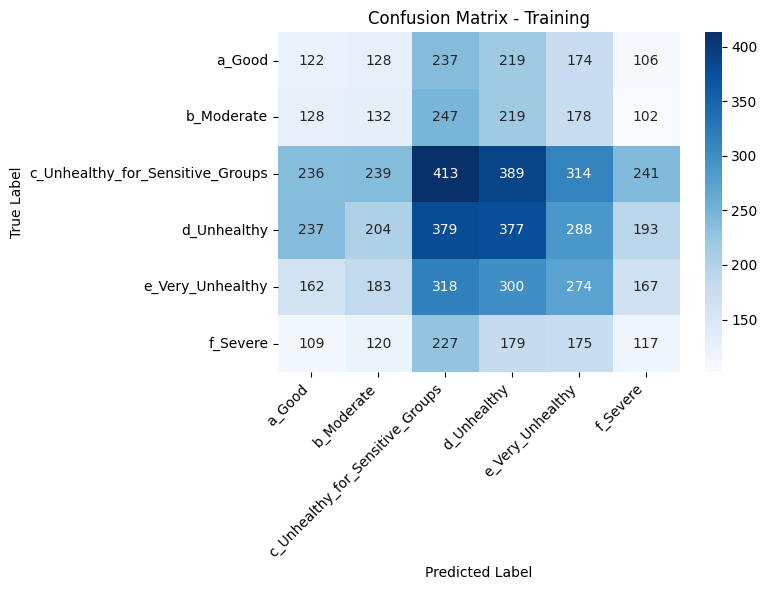

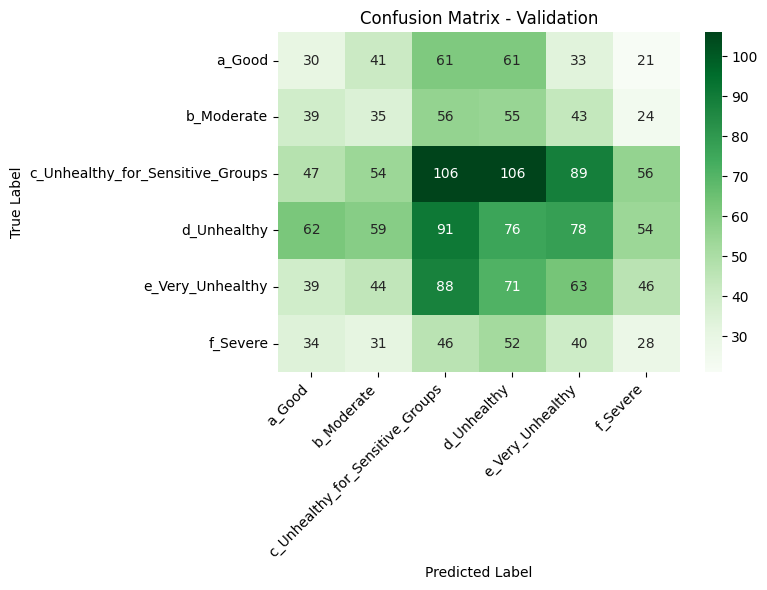

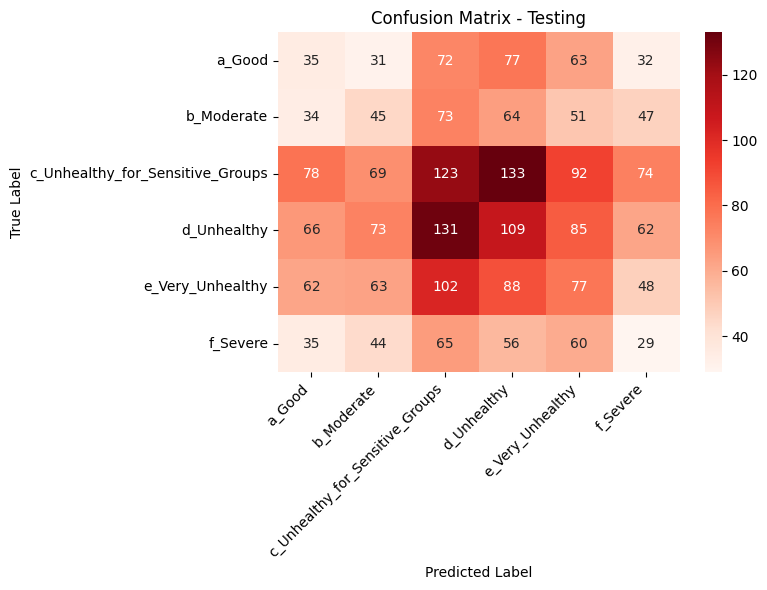

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
train_cm = confusion_matrix(train_generator.classes, train_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()
